In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

# Engine data

In [3]:
engine1 = pd.read_csv("UIPA.HMD8310H.Engine1.csv")
engine1.shape

/tmp/ipykernel_5783/2363869710.py:1: DtypeWarning: Columns (152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,

(443252, 702)

In [4]:
engine1["battery_only"] = engine1["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)

In [5]:
engine2 = pd.read_csv("UIPA.HMD8310H.Engine2.csv")
engine2.shape

/tmp/ipykernel_5783/3469547296.py:1: DtypeWarning: Columns (152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,

(443369, 702)

In [6]:
engine2["battery_only"] = engine2["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)

In [7]:
merged_df = pd.merge(engine1[["aIEngineLoad", "time", "battery_only"]], engine2[["aIEngineLoad", "time"]], on='time', how='inner')
merged_df["total_load"] = merged_df["aIEngineLoad_x"] + merged_df["aIEngineLoad_y"]
merged_df.shape

(369304, 5)

In [10]:
mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")
mgo["total_vol"] = mgo["MGO_STOR_TK_C_CALC_VOL"] + mgo["MGO_STOR_TK_S_CALC_VOL"] + mgo["NO1_MGO_SERV_TK_CALC_VOL"] + mgo["NO2_MGO_SERV_TK_CALC_VOL"]

In [11]:
engine_and_fuel_df = pd.merge(merged_df, mgo[["total_vol", "time"]], on='time', how='inner')
engine_and_fuel_df.shape

(107225, 6)

# Battery data

In [14]:
battery_data = pd.read_csv("EP_Battery.Thing_HMD8310.csv")
battery_data.shape

/tmp/ipykernel_5783/2709348869.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  battery_data = pd.read_csv("EP_Battery.Thing_HMD8310.csv")


(477586, 111)

In [21]:
battery_columns_to_use = ["AVG_PACK_SOC", "Current", "Voltage", "time"]
for i in range(1, 8):
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_BATT_VOL")
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_CURR")
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_SOC")

In [22]:
final_df = pd.merge(merged_df, battery_data[battery_columns_to_use], on='time', how='inner')
final_df.shape

(107380, 29)

## Find relationship between battery power and SOC

<Axes: >

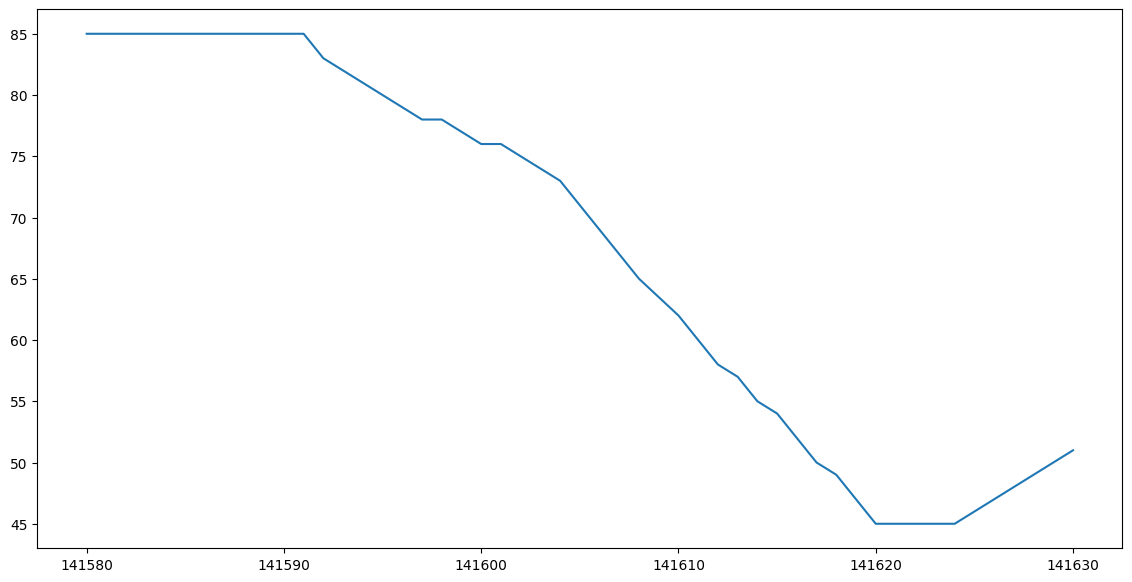

In [61]:
plt.figure(figsize=(14, 7))
filtered_soc_data = battery_data[battery_data["AVG_PACK_SOC"]<=100]
filtered_soc_data.loc[141580:141630, "PACK1_CRIDATA_SOC"].plot()

In [89]:
upper_bound = 100
lower_bound = 20
segments = []
start_idx = None

for idx in filtered_soc_data.index:
    soc_value = filtered_soc_data.loc[idx, 'AVG_PACK_SOC']
    if start_idx is None and soc_value < upper_bound:
        start_idx = idx  # start of a new segment
    elif start_idx is not None and soc_value < lower_bound:
        # end of the current segment
        if idx - 1 != start_idx:  # check to ensure the segment is more than 1 data point
            segments.append((start_idx, idx - 1))
        start_idx = None

<Axes: >

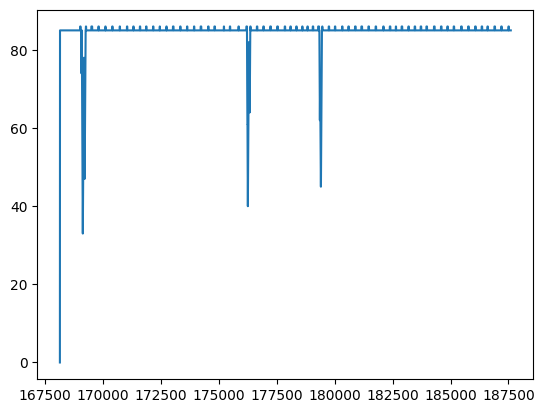

In [129]:
avg_soc_good_segment_idx = [16, 25, 31] # I stopped checking at 31

good_data_start_idx = [116300, 141580, 147400, 148800, 154750, 156000, 169000, 176100, 179300]
good_data_end_idx = [116500, 141650, 147500, 149000, 154950, 156200, 169300, 176400, 179500]

start, end = segments[31]
soc_data = filtered_soc_data.loc[start:end, "AVG_PACK_SOC"]
soc_data.plot()

<Axes: >

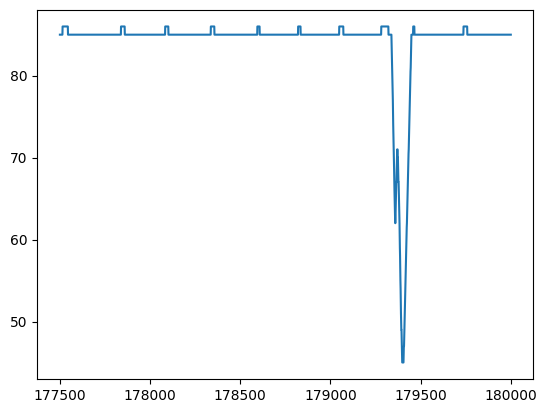

In [134]:
soc_data = filtered_soc_data.loc[177500:180000, "AVG_PACK_SOC"]
soc_data.plot()

<Axes: >

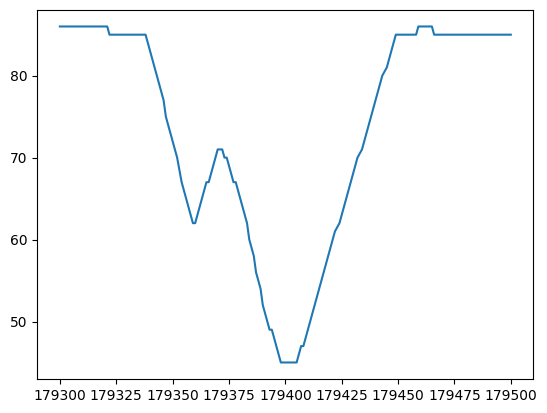

In [136]:
soc_data = filtered_soc_data.loc[179300:179500, "AVG_PACK_SOC"]
soc_data.plot()

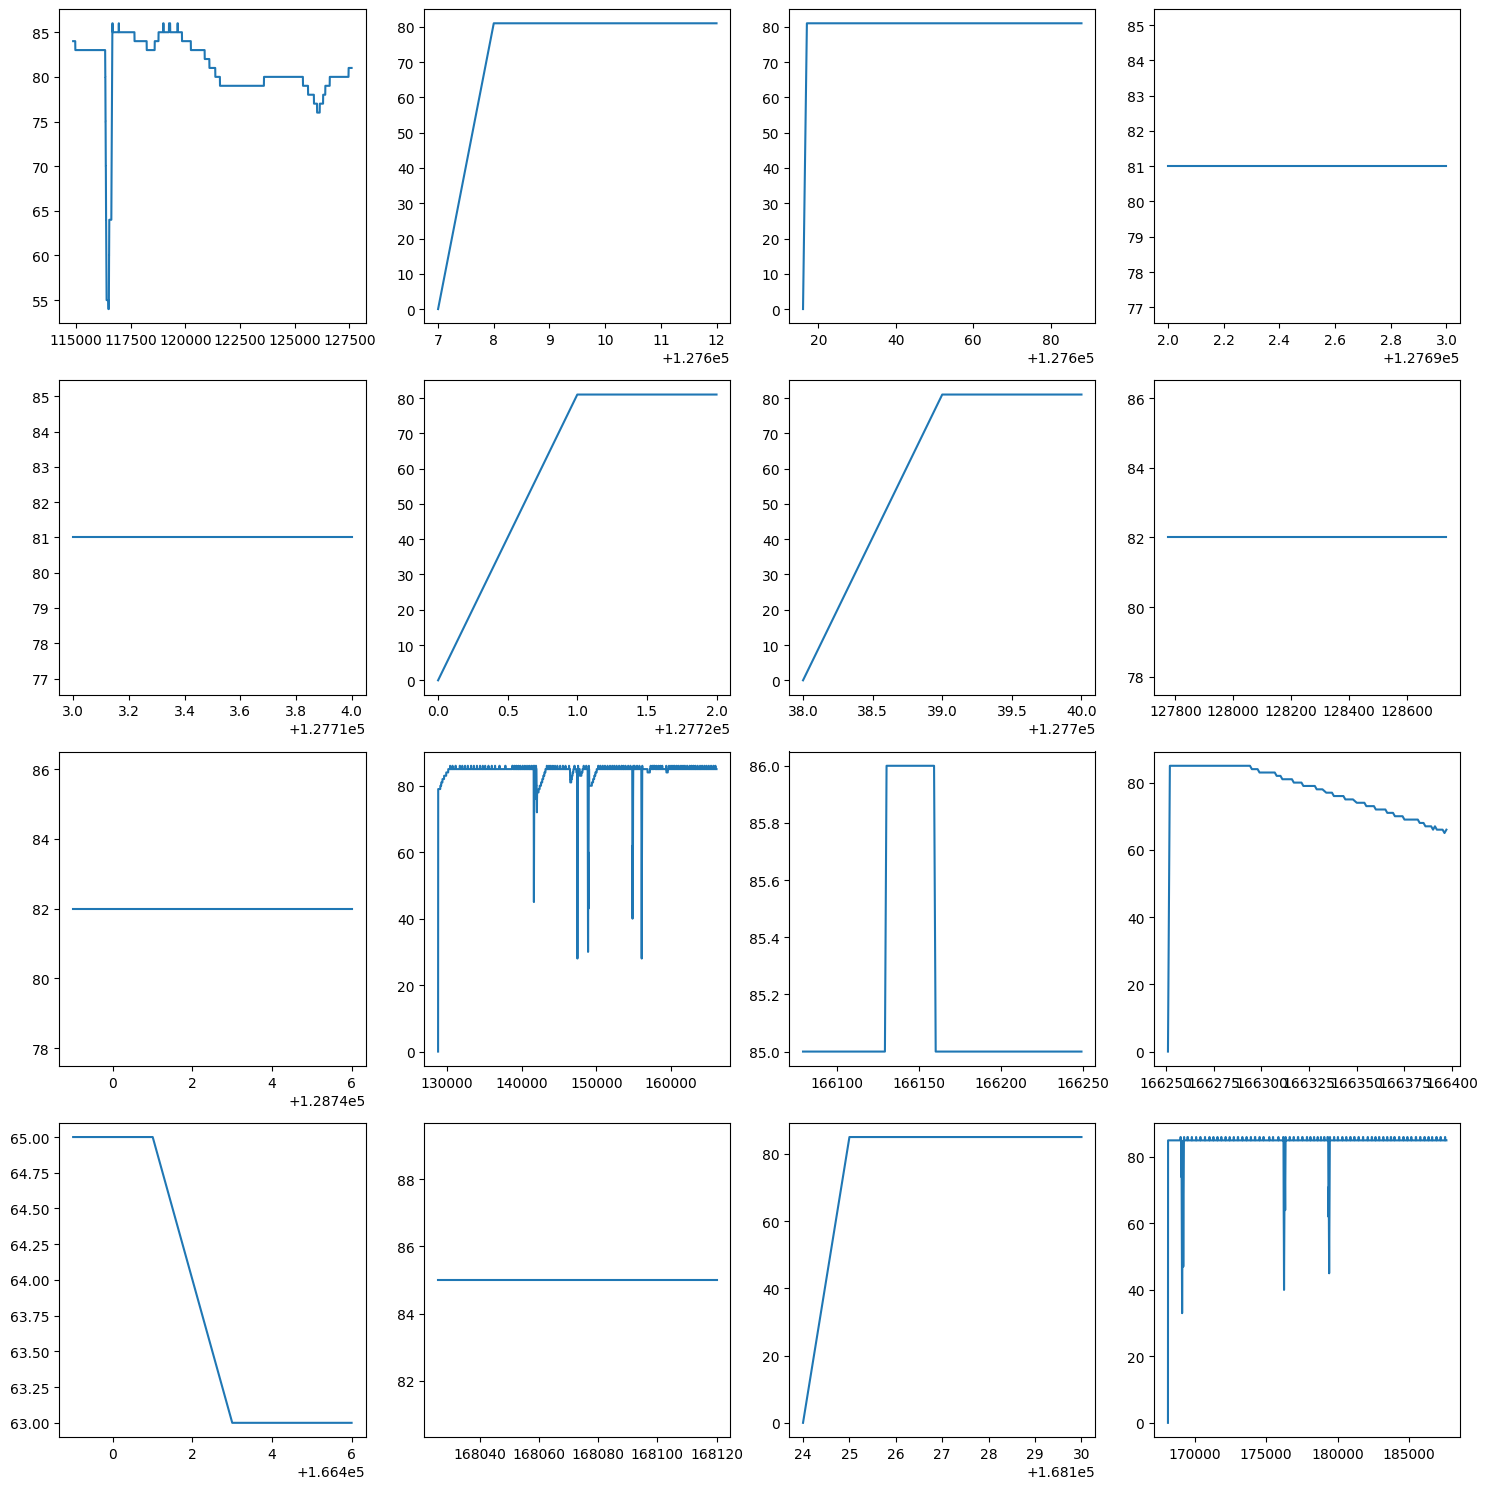

In [95]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15)) # 4x4 grid of axes

for i in range(4):
    for j in range(4):
        start, end = segments[16+4*i + j]
        soc_data = filtered_soc_data.loc[start:end, "AVG_PACK_SOC"]
        axs[i, j].plot(soc_data)
        # axs[i, j].set_title(f'Plot {4*i + j + 1}')

plt.tight_layout() # Adjusts the plots to fit into the figure area.
plt.show()

# for start, end in segments[10:20]:
#     plt.figure()
#     soc_data = filtered_soc_data.loc[start:end, "AVG_PACK_SOC"]
#     soc_data.plot()

# Optimize power split

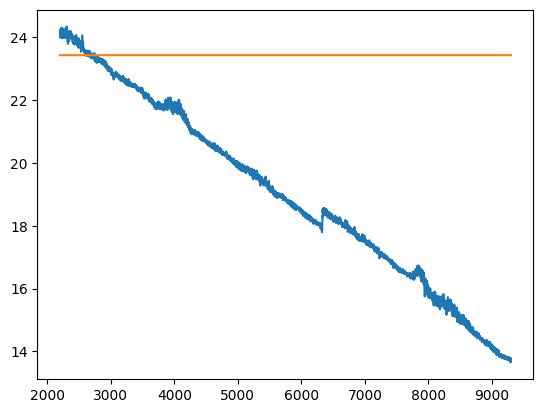

In [23]:
noise_start_point = 2200
noise_end_point = 9300
fuel_data = engine_and_fuel_df["total_vol"][noise_start_point:noise_end_point]
load_data = engine_and_fuel_df["total_load"][noise_start_point:noise_end_point]
(fuel_data).plot()
plt.plot(load_data.index, np.ones(load_data.shape)*load_data.mean()/10)

<Axes: >

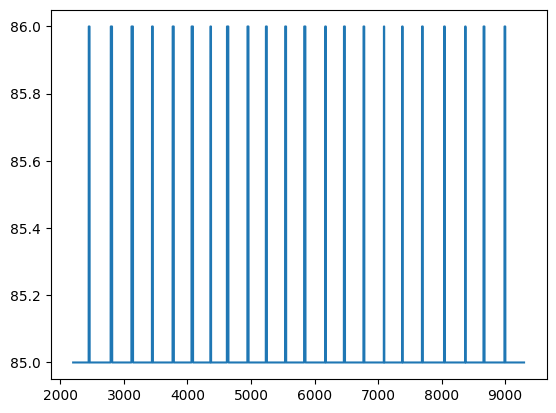

In [37]:
noise_start_point = 2200
noise_end_point = 9300
final_df["PACK1_CRIDATA_SOC"][noise_start_point:noise_end_point].plot()

In [28]:
final_df.columns

Index(['aIEngineLoad_x', 'time', 'battery_only', 'aIEngineLoad_y',
       'total_load', 'AVG_PACK_SOC', 'Current', 'Voltage',
       'PACK1_CRIDATA_BATT_VOL', 'PACK1_CRIDATA_CURR', 'PACK1_CRIDATA_SOC',
       'PACK2_CRIDATA_BATT_VOL', 'PACK2_CRIDATA_CURR', 'PACK2_CRIDATA_SOC',
       'PACK3_CRIDATA_BATT_VOL', 'PACK3_CRIDATA_CURR', 'PACK3_CRIDATA_SOC',
       'PACK4_CRIDATA_BATT_VOL', 'PACK4_CRIDATA_CURR', 'PACK4_CRIDATA_SOC',
       'PACK5_CRIDATA_BATT_VOL', 'PACK5_CRIDATA_CURR', 'PACK5_CRIDATA_SOC',
       'PACK6_CRIDATA_BATT_VOL', 'PACK6_CRIDATA_CURR', 'PACK6_CRIDATA_SOC',
       'PACK7_CRIDATA_BATT_VOL', 'PACK7_CRIDATA_CURR', 'PACK7_CRIDATA_SOC'],
      dtype='object')